In [2]:
import numpy as np
import pandas as pd

from graph_tool.all import *

In [66]:
edges_user = pd.read_csv("data/u2u_6month.csv", index_col = 0)
edges_a2q = pd.read_csv("data/a2q_6month.csv", index_col = 0)

# Remove ties to itself
edges_user = edges_user.loc[edges_user['source'] != edges_user['target']]
edges_a2q = edges_a2q.loc[edges_a2q['source'] != edges_a2q['target']]

In [68]:
verts = pd.read_csv("data/vertices_seed111.csv", names = ['numbers'], dtype='int64')
verts = [i for i in verts.numbers]

edges_user_src = edges_user[edges_user['source'].isin(verts)]
edges_user_tgt = edges_user[edges_user['target'].isin(verts)]

edges_a2q_src = edges_a2q[edges_a2q['source'].isin(verts)]
edges_a2q_tgt = edges_a2q[edges_a2q['target'].isin(verts)]

In [70]:
edges_user = edges_user_src.append(edges_user_tgt)
edges_user.drop_duplicates(inplace=True)
edges_a2q = edges_a2q_src.append(edges_a2q_tgt)
edges_a2q.drop_duplicates(inplace=True)
edges = edges_a2q.append(edges_user)
edges.reset_index(inplace=True)
edges = edges.drop(columns=['index'])

In [71]:
edges_user.to_csv('data/user.csv')
edges_a2q.to_csv('data/a2q.csv')
edges.to_csv('data/projected_network.csv')

In [6]:
g = Graph(directed=False)
vmap = g.add_edge_list(edges.values, hashed=True)

In [7]:
g2 = Graph(directed=False)
vmap2 = g2.add_edge_list(edges_user.values, hashed=True)

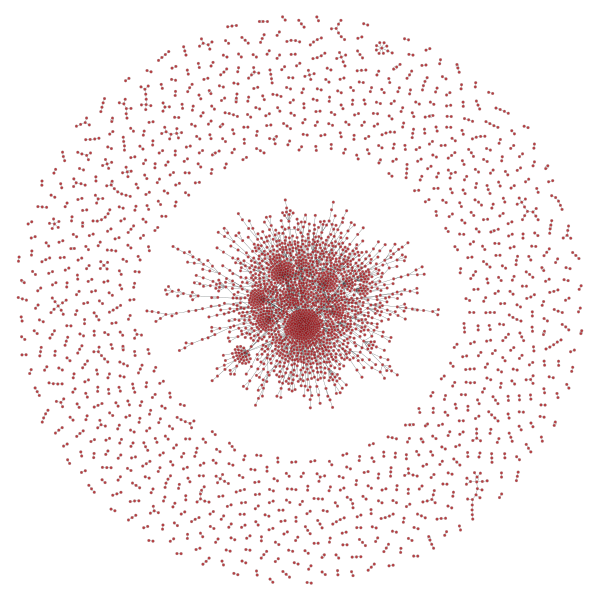

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9637f26400, at 0x7f9637f1b400>

In [19]:
graph_draw(g2)

In [8]:
g3 = Graph(directed=False)
vmap3 = g3.add_edge_list(edges_a2q.values, hashed=True)

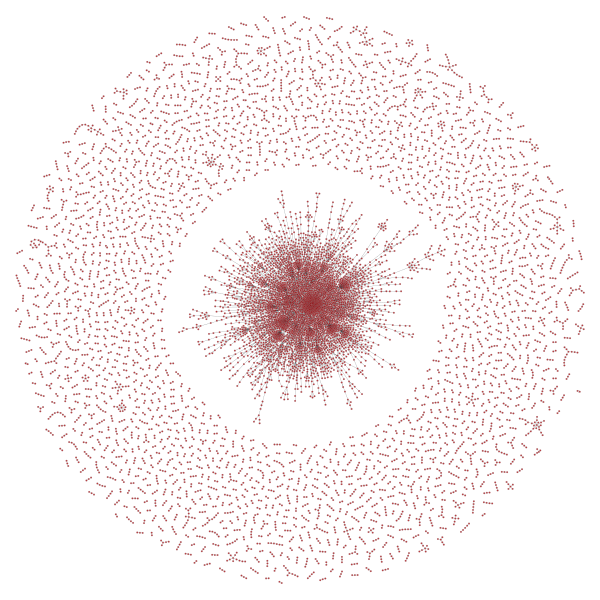

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9637f2ad30, at 0x7f96382c87b8>

In [21]:
graph_draw(g3)

## Membership Closure, Start date is 2008-08-01 ##

In [3]:
edges_user = pd.read_csv('data/user.csv', index_col = 0)
edges_a2q = pd.read_csv('data/a2q.csv', index_col = 0)

In [4]:
def get_nodes_time(edges, t):
    """
    Parameters: 
    edges: dataframe of edges
    time: time in string
    
    Returns: Tuple of dataframe at time t, nodes at time t
    """
    df = edges.loc[edges['time'] < t]
    nodes = set(list(df['source']) + list(df['target']))
    return df, nodes

In [21]:
def get_nodes_focus(nodes_user, nodes_a2q):
    """
    Parameters:
    nodes_user: dataframe of user at time t
    nodes_a2q: dataframe of a2q at time t
    
    Returns: Tuple of list of nodes in and not in focus
    """
    nodes_in_focus = [n for n in nodes_user if n in nodes_a2q]
    nodes_not_in_focus = [n for n in nodes_user if n not in nodes_a2q]
    return nodes_in_focus, nodes_not_in_focus

In [24]:
def get_links(edges_user, nodes_enter_focus):
    """
    Parameters:
    edges_user: dataframe of user edges at time t
    nodes_enter_focus: list of nodes entering the focus at time t
    
    Returns: set of nodes that appear in the edges
    """
    links_src = edges_user[edges_user['source'].isin(nodes_enter_focus)]
    links_tgt = edges_user[edges_user['target'].isin(nodes_enter_focus)]
    links = links_src.append(links_tgt)
    links.drop_duplicates(inplace=True)
    links_nodes = set(list(links['source']) + list(links['target']))
    return links_nodes

In [59]:
def proportion_nodes_part_of_focus(nodes_a2q, links_nodes, nodes_enter_focus):
    """
    Parameters: 
    nodes_a2q: dataframe of a2q at time t
    links_nodes: nodes with ties to nodes entering focus
    nodes_enter_focus: list of nodes entering the focus at time t
    
    Returns: portion of ties which are already in the focus
    """
    # Get nodes which aren't part of nodes entering focus
    links_nodes = [n for n in links_nodes if n not in nodes_enter_focus]
    # Check if they are member of focus
    member_of_focus = [i in nodes_a2q for i in links_nodes]
    # Get portion of nodes in focus
    try:
        portion = member_of_focus.count(True)/len(member_of_focus)
    except:
        portion = 0
    return portion

In [76]:
def automate(edges_user, edges_a2q, nodes_not_in_focus_prev, time):
    """
    Parameters: 
    edges_user: dataframe of user's edges
    edges_a2q: dataframe of a2q's edges
    nodes_not_in_focus_prev: list of nodes not in the focus from previous time
    time: Date as a string
    
    Returns: 3-Tuple of nodes in focus, nodes not in focus, portion of ties which are already in the focus
    """
    edges_user, nodes_user = get_nodes_time(edges_user, time)
    edges_a2q,  nodes_a2q = get_nodes_time(edges_a2q, time)
    
    # Get only nodes in user space that is and is not part of the focus
    nodes_in_focus, nodes_not_in_focus = get_nodes_focus(nodes_user, nodes_a2q)
    
    # Compare with previous time
    nodes_enter_focus = [n for n in nodes_not_in_focus_prev if n not in nodes_not_in_focus]
    
    # Find number of links for nodes that enter focus has at current t in user space
    links_nodes = get_links(edges_user, nodes_enter_focus)
    
    # Get portion of nodes which aren't part of nodes entering focus and check if they are a member of focus
    portion = proportion_nodes_part_of_focus(nodes_a2q, links_nodes, nodes_enter_focus)
    
    return nodes_in_focus, nodes_not_in_focus, portion

In [70]:
## t0
# End date is 2008-09-01
edges_user_t0, nodes_user_t0 = get_nodes_time(edges_user, '2008-09-01')
edges_a2q_t0,  nodes_a2q_t0 = get_nodes_time(edges_a2q, '2008-09-01')
# Get only nodes in user space that is and is not part of the focus
nodes_in_focus_t0 = [n for n in nodes_user_t0 if n in nodes_a2q_t0]
nodes_not_in_focus_t0 = [n for n in nodes_user_t0 if n not in nodes_a2q_t0]

## t1
# End date is 2008-10-01
nodes_in_focus_t1, nodes_not_in_focus_t1, portion_t1 = automate(edges_user, edges_a2q, nodes_not_in_focus_t0, '2008-10-01')

# t2
# End date is 2008-11-01
nodes_in_focus_t2, nodes_not_in_focus_t2, portion_t2 = automate(edges_user, edges_a2q, nodes_not_in_focus_t1, '2008-11-01')

# t3
## End date is 2008-12-01
nodes_in_focus_t3, nodes_not_in_focus_t3, portion_t3 = automate(edges_user, edges_a2q, nodes_not_in_focus_t2, '2008-12-01')

# t4
## End date is 2009-01-01
nodes_in_focus_t4, nodes_not_in_focus_t4, portion_t4 = automate(edges_user, edges_a2q, nodes_not_in_focus_t3, '2009-01-01')

# t5
## End date is 2009-02-01
nodes_in_focus_t5, nodes_not_in_focus_t5, portion_t5 = automate(edges_user, edges_a2q, nodes_not_in_focus_t4, '2009-02-01')